In [29]:
# Description: This script is used to create a workflow for the data analysis

import pandas as pd
import glob
import os
from adaptive_scaling import adaptive_scaling
from model_tuning import model_tuning_CV

# Script workflow:
# - load data
# - scaling
# - split into training and testing based on data gaps
# - machine learning models and applying hyperparameter search grids

################################################################################
### Workflow Parameters
################################################################################

# Define features to run as input variables for the models:
features = [
    "SWin",
    "LWin",
    "Tair",
    "RH_air",
    "prec", 
    "u",  
    "snow_cover",
    "hour",
    "doy"
    ]

# Choose the gaps dataset - either structured or random gaps
gaps_data_file = 'structured_gaps_1' # 'random_gaps_1' -- values from 1 to 5 for diff versions

# Define the cross-validation strategy:
scoring = 'neg_mean_absolute_error'   # e.g. 'neg_mean_squared_error', 'r2', 'neg_root_mean_squared_error. More available methods for regression evaluation (scoring): https://scikit-learn.org/1.5/modules/model_evaluation.html#scoring-parameter)
cv = 3  # Number of cross-validation folds


################################################################################
### Data 
################################################################################


##### Load the synthetic dataset:
# a. Load single CSV files in separate dfs
# b. Merge the dfs into one single "synthetic_dataset"

folder_path = '../../data/synthetic_dataset'

csv_files = glob.glob(os.path.join(folder_path, '*.csv')) # use glob library to find all CSV files

dfs = [] #to store individual DataFrames.

for file in csv_files:
    # Read each CSV file into a Pandas DataFrame.
    # 'parse_dates' argument ensures the 'time' column is interpreted as datetime objects.
    data = pd.read_csv(file, parse_dates=['time'], sep=',')
    
    dfs.append(data)

syn_ds = dfs[0] # Start with the first DataFrame as the base for merging.

for data in dfs[1:]:
    # Merge each subsequent DataFrame with the base DataFrame (`syn_ds`).
    # The merge is done using an ordered merge on the 'time' column.
    # This ensures that the merged dataset remains sorted by 'time'.
    syn_ds = pd.merge_ordered(syn_ds, data, on='time')

#syn_ds


In [27]:
#-------------------------------------------------------------------------------
# Feautures and target variables:

syn_ds["time"] = pd.to_datetime(syn_ds["time"])
syn_ds["doy"] = syn_ds["time"].dt.dayofyear
syn_ds["hour"] = syn_ds["time"].dt.hour

y = syn_ds["LE"]
X = syn_ds[features]

#X

In [28]:
scaled_X, scaled_info = adaptive_scaling(X, cyclic_features=['doy', 'hour'])
#scaled_X.plot(subplots=True, figsize=(12,24))
#scaled_info

In [24]:
#-------------------------------------------------------------------------------
# Split into training and testing datasets based on gaps in LE:

# Function to load data gaps dataset
def load_data_gaps(file_name):
    return pd.read_csv(f'../../data/LE-gaps/{file_name}.csv', parse_dates=['time'], sep=',')

LE_gaps = load_data_gaps(gaps_data_file)

# select X and y where LE_gaps is not null
X_train = X[LE_gaps['LE_gaps'].notnull()]
y_train = y[LE_gaps['LE_gaps'].notnull()]

# The following test set is for where there is data gaps
X_test = X[LE_gaps['LE_gaps'].isnull()]
y_test = y[LE_gaps['LE_gaps'].isnull()]

assert X_train.index.union(X_test.index).equals(X.index), "X_train and X_test do not cover all rows of X!"


<AxesSubplot:>

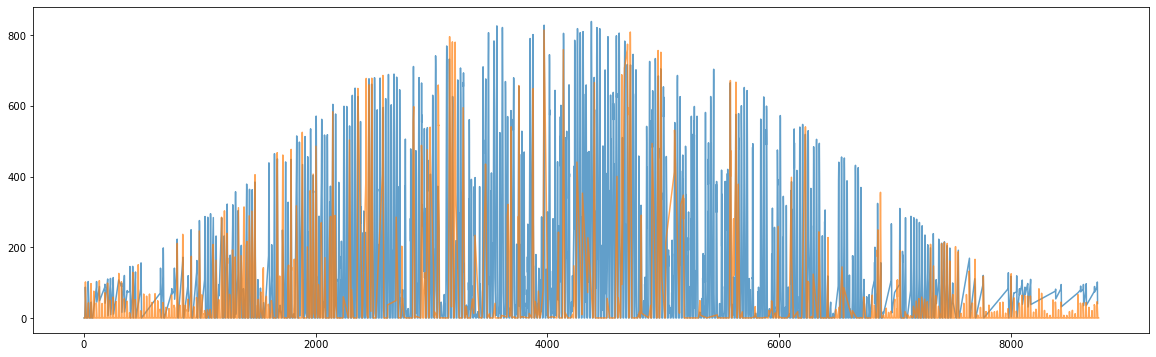

In [25]:
#X['SWin'].plot(figsize=(12,6))
X_train['SWin'].plot(figsize=(20,6), alpha=0.7)
X_test['SWin'].plot(figsize=(20,6), alpha=0.7)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
 
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

RF_best_model, RF_y_pred = model_tuning_CV(RandomForestRegressor(), param_grid, cv, scoring)

<AxesSubplot:>

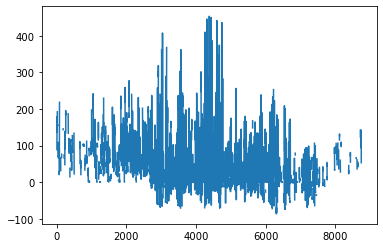

In [ ]:
# Description: This script is used to create a workflow for the data analysis

import pandas as pd
import glob
import os
from ML_lib import *  # Assuming your tuning and evaluation functions are here

# packages:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import xgboost as xgb
#from bartpy.sklearnmodel import SklearnModel as BART

print("Imported libraries\n")

# Script workflow:
# - load data
# - scaling
# - split into training and testing based on data gaps
# - machine learning models and applying hyperparameter search grids

################################################################################
### Workflow Parameters
################################################################################

# Define features to run as input variables for the models:
features = [
    "SWin",
    "LWin",
    "Tair",
    "RH_air",
    "prec",
    "u",
    "snow_cover",
    "hour",
    "doy"
    ]

# Choose the gaps dataset - either structured or random gaps
gaps_data_file = 'structured_gaps_1' # 'random_gaps_1' -- values from 1 to 5 for diff versions

# Define the cross-validation strategy:
scoring = 'neg_mean_absolute_error'   # e.g. 'neg_mean_squared_error', 'r2', 'neg_root_mean_squared_error. More available methods for regression evaluation (scoring): https://scikit-learn.org/1.5/modules/model_evaluation.html#scoring-parameter)
cv = 3  # Number of cross-validation folds


################################################################################
### Data
################################################################################


##### Load the synthetic dataset:
# a. Load single CSV files in separate dfs
# b. Merge the dfs into one single "synthetic_dataset"

folder_path = '../../data/synthetic_dataset'

csv_files = glob.glob(os.path.join(folder_path, '*.csv')) # use glob library to find all CSV files

dfs = [] #to store individual DataFrames.

for file in csv_files:
    data = pd.read_csv(file, parse_dates=['time'], sep=',')
    # 'parse_dates' argument ensures the 'time' column is interpreted as datetime objects.
    
    dfs.append(data)

syn_ds = dfs[0] # Start with the first DataFrame as the base for merging.

for data in dfs[1:]:
    # Merge each subsequent DataFrame with the base DataFrame (`syn_ds`).
    # The merge is done using an ordered merge on the 'time' column.
    # This ensures that the merged dataset remains sorted by 'time'.
    syn_ds = pd.merge_ordered(syn_ds, data, on='time')

#-------------------------------------------------------------------------------
# Features and target variables:

syn_ds["time"] = pd.to_datetime(syn_ds["time"])
syn_ds["doy"] = syn_ds["time"].dt.dayofyear
syn_ds["hour"] = syn_ds["time"].dt.hour

y = syn_ds["LE"]
X = syn_ds[features]

#-------------------------------------------------------------------------------
# Split into training and testing datasets based on gaps in LE:

# Function to load data gaps dataset
def load_data_gaps(file_name):
    return pd.read_csv(f'../data/LE-gaps/{file_name}.csv', parse_dates=['time'], sep=',')

LE_gaps = load_data_gaps(gaps_data_file)

# Select X and y where LE_gaps is not null
X_train = X[LE_gaps['LE_gaps'].notnull()]
y_train = y[LE_gaps['LE_gaps'].notnull()]

# The following test set is for where there are data gaps
X_test = X[LE_gaps['LE_gaps'].isnull()]
y_test = y[LE_gaps['LE_gaps'].isnull()]

print("Created training and testing datasets")

################################################################################
# MACHINE LEARNING MODELS
################################################################################

#-------------------------------------------------------------------------------

# LINEAR REGRESSION (No hyperparameters to tune)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
LR_metrics = evaluate_model(lr_model, X_test, y_test, scoring)

print("\n=== LINEAR REGRESSION RESULTS ===")
print(f"Test Metrics: {LR_metrics}")

In [ ]:
# Description: This script is used to create a workflow for the data analysis

import pandas as pd
import glob
import os
from ML_lib import * 

# packages:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#import xgboost as xgb
#from bartpy.sklearnmodel import SklearnModel as BART